In [191]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import pandas as pd
from evaluation import evaluation
from torch_geometric.loader import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
octa_dr_dict = {"Healthy": 0, "DM": 1, "PDR": 2, "Early NPDR": 3, "Late NPDR": 4}

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

In [176]:
octa_dr_dict_update = {"Healthy": 0, "DM": 1, "PDR": 2, "Early NPDR": 3, "Late NPDR": 4}
train_dataset.update_class(octa_dr_dict_update)
test_dataset.update_class(octa_dr_dict_update)

In [177]:
# do data imputation
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

# extract graph features
train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)# 
train_g_feature_dict = train_g_extractor.get_feature_dict()
train_g_faz_feature_dict = train_g_extractor.get_faz_feature_dict()

test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)# 
test_g_feature_dict = test_g_extractor.get_feature_dict()
test_g_faz_feature_dict = test_g_extractor.get_faz_feature_dict()

In [178]:
#extract segmentation features
seg_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_seg"
seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
seg_feature_dict = seg_extractor.get_feature_dict()


In [179]:
# combined feature dict

def create_combined_feature_dict(g_feature_dict, faz_feature_dict, seg_feature_dict, dataset):
    comb_feature_dict = {}
    for key, val in g_feature_dict.items():
        comb_feature_dict[key] = (np.concatenate([val["graph_1"],val["graph_2"], np.array(faz_feature_dict[key]), seg_feature_dict[key]], axis = 0), int(dataset.hetero_graphs[key].y[0]))
    return comb_feature_dict

In [180]:
train_comb_feature_dict = create_combined_feature_dict(train_g_feature_dict,train_g_faz_feature_dict, seg_feature_dict, train_dataset)
test_comb_feature_dict = create_combined_feature_dict(test_g_feature_dict,test_g_faz_feature_dict, seg_feature_dict, test_dataset)

In [181]:
x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
y_train = np.array([val[1] for val in train_comb_feature_dict.values()])

x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
y_test = np.array([val[1] for val in test_comb_feature_dict.values()])

In [182]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV


param_grid_rf = {'max_depth': [5, 6, 8, 9, 10], 'max_features': ["sqrt", "log2"]}


rf = RandomForestClassifier(class_weight='balanced')
clf_rf = GridSearchCV(rf, param_grid_rf, scoring = "balanced_accuracy")
clf_rf.fit(x_train, y_train)

print(clf_rf.best_score_)
print(clf_rf.best_params_)

rf_best = clf_rf.best_estimator_
_=rf_best.fit(x_train, y_train)


0.4209459025404347
{'max_depth': 5, 'max_features': 'log2'}


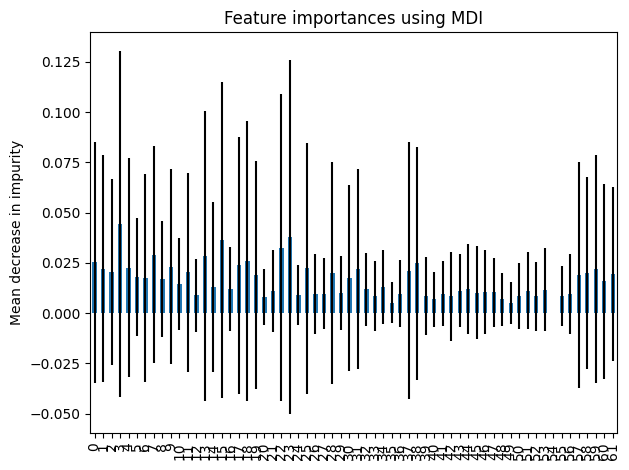

In [183]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features

0.5958549222797928
0.5237120359955006


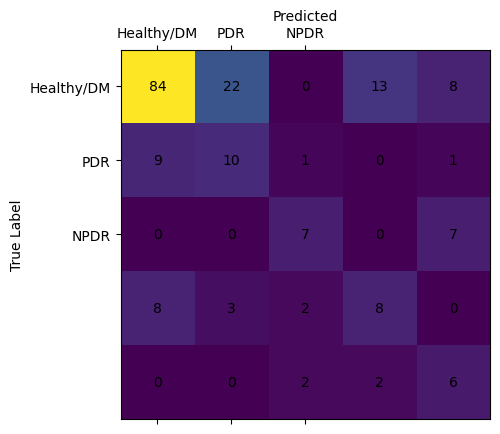

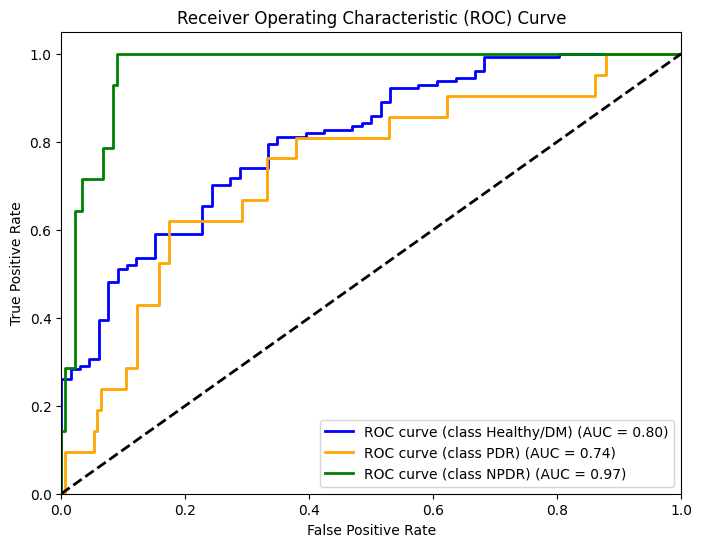

In [184]:
y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, ["Healthy/DM","PDR", "NPDR"], ax) #, "Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()
y_prob = rf_best.predict_proba(x_test)
evaluation.plot_roc_curve(y_test, y_prob, class_labels = ["Healthy/DM", "PDR", "NPDR"])  #["Healthy","DM", "PDR", "Early NPDR", "Late NPDR"] 


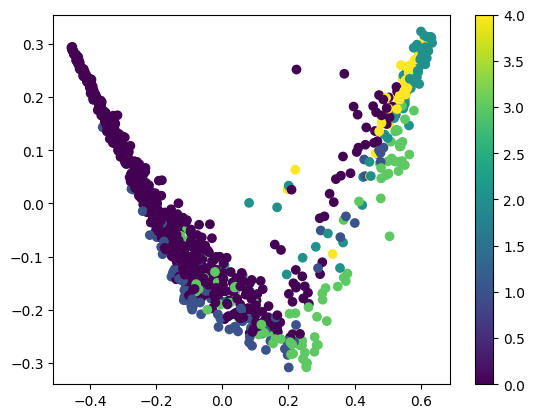

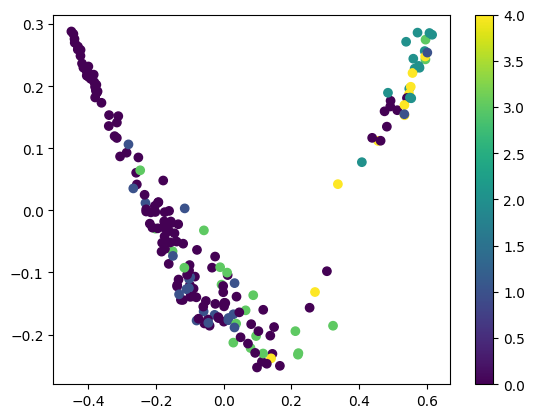

In [185]:
# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(y_prob_train)
pca_train = pca.transform(y_prob_train)

sc = plt.scatter(pca_train[:,0],pca_train[:,1], c = y_train)
plt.colorbar(sc)
plt.show()

pca_test = pca.transform(y_prob)
sc = plt.scatter(pca_test[:,0],pca_test[:,1], c = y_test)
plt.colorbar(sc)
plt.show()


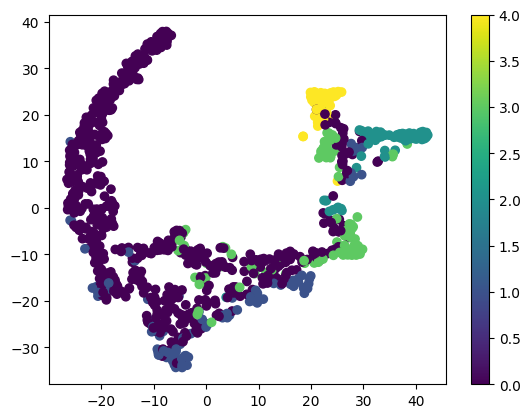

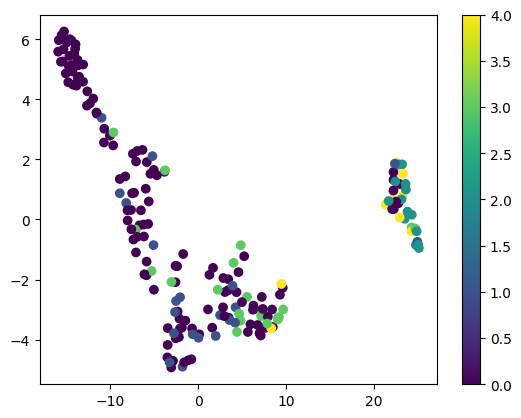

In [186]:
# plot tsne embedding

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
y_prob_train_tsne = tsne.fit_transform(y_prob_train)
y_prob_tsne = tsne.fit_transform(y_prob)

sc = plt.scatter(y_prob_train_tsne[:,0],y_prob_train_tsne[:,1], c = y_train)
plt.colorbar(sc)
plt.show()

sc = plt.scatter(y_prob_tsne[:,0],y_prob_tsne[:,1], c = y_test)
plt.colorbar(sc)
plt.show()


#fig, ax = plt.subplots(1,3, figsize = (18,5))
#ax[0].scatter(y_prob_train[:,0],y_prob_train[:,1], c = y_train)
#ax[1].scatter(y_prob_train[:,0],y_prob_train[:,2], c = y_train)
#ax[2].scatter(y_prob_train[:,1],y_prob_train[:,2], c = y_train)
#sc = ax[2].scatter(y_prob_train[:,1],y_prob_train[:,2], c = y_train)
#plt.show()
#
#fig, ax = plt.subplots(1,3, figsize = (18,5))
#ax[0].scatter(y_prob[:,0],y_prob[:,1], c = y_test)
#ax[1].scatter(y_prob[:,0],y_prob[:,2], c = y_test)
#sc = ax[2].scatter(y_prob[:,1],y_prob[:,2], c = y_test)
#plt.colorbar(sc)
#plt.show()


In [187]:
param_grid_rf = {'max_depth': [5, 6, 8, 9, 10], 'max_features': ["sqrt", "log2"]}

from itertools import product

rf = RandomForestClassifier(class_weight='balanced')

best_params = None
best_bal_accuracy = 0

# Hyperparameter search loop
for param_set in product(*param_grid_rf.values()):
    current_params = dict(zip(param_grid_rf.keys(), param_set))

    # Train the model on the training set
    current_model = RandomForestClassifier(**current_params, class_weight='balanced')
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)

    # Update best parameters if current model is better
    if current_accuracy > best_bal_accuracy:
        best_bal_accuracy = current_accuracy
        best_params = current_params


rf_best = RandomForestClassifier(**best_params, class_weight='balanced')
_=rf_best.fit(x_train, y_train)


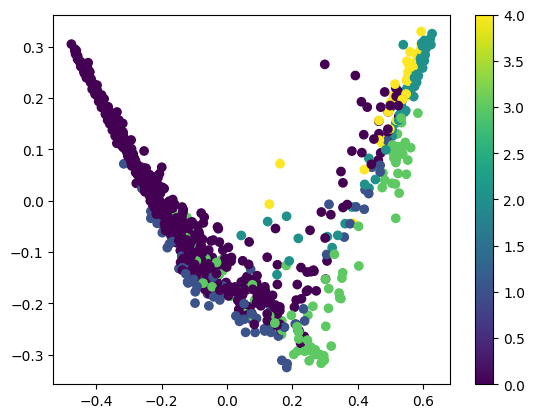

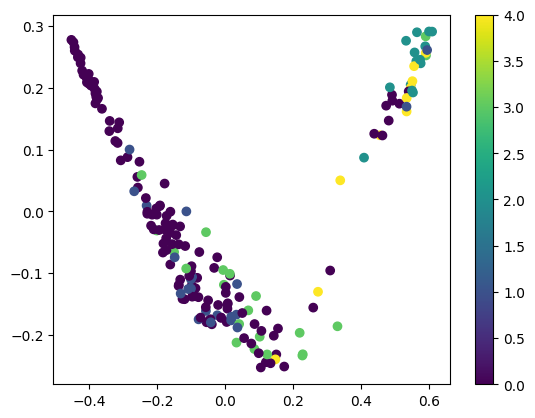

In [188]:


# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(y_prob_train)
pca_train = pca.transform(y_prob_train)

sc = plt.scatter(pca_train[:,0],pca_train[:,1], c = y_train)
plt.colorbar(sc)
plt.show()

pca_test = pca.transform(y_prob)
sc = plt.scatter(pca_test[:,0],pca_test[:,1], c = y_test)
plt.colorbar(sc)
plt.show()


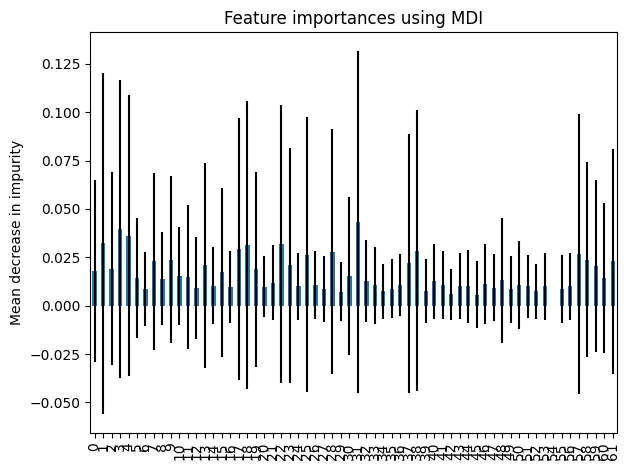

In [189]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features

0.616580310880829
0.5214023247094113


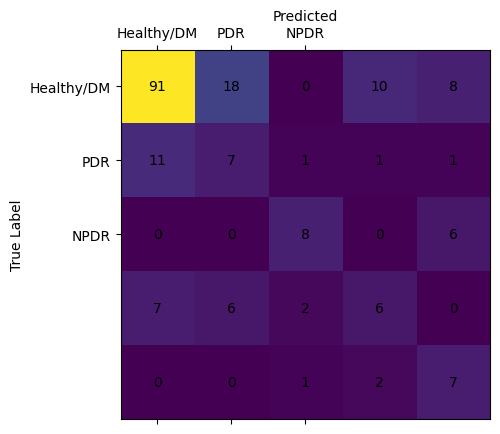

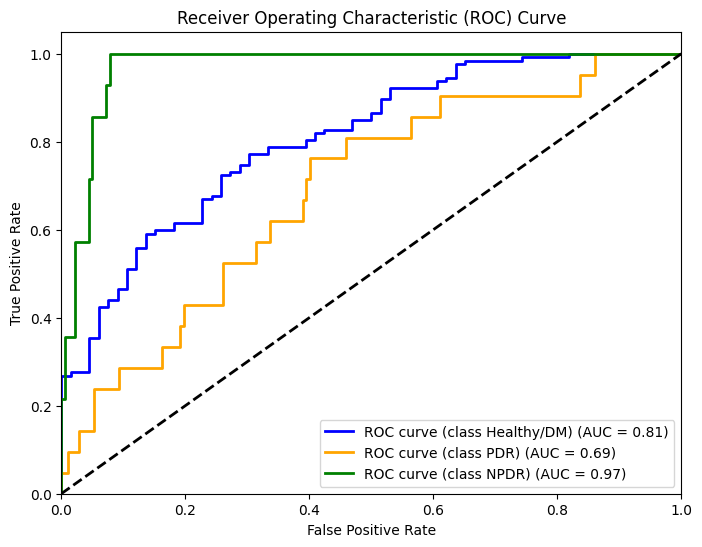

In [190]:
y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, ["Healthy/DM","PDR", "NPDR"], ax) #, "Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()
y_prob = rf_best.predict_proba(x_test)
evaluation.plot_roc_curve(y_test, y_prob, class_labels = ["Healthy/DM", "PDR", "NPDR"])  #["Healthy","DM", "PDR", "Early NPDR", "Late NPDR"] 
